In [38]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torchvision import transforms
import torch
import cv2
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class LaticiferPatchTrain(Dataset):
    def __init__(
        self,
        feature_dirs,
        patch_size=(512, 512),
        patches_per_image=20,
        positive_ratio=0.8,
        dist_transform=False,
        fg_threshold=0.03,
        filenames=None,
        curriculum_level=0
    ):
        self.feature_dirs = feature_dirs
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image
        self.positive_ratio = positive_ratio
        self.dist_transform = dist_transform
        self.fg_threshold = fg_threshold
        self.curriculum_level = curriculum_level

        self.filenames = filenames if filenames is not None else sorted(os.listdir(self.feature_dirs['mask']))[:1]
        additional_targets = {
            key: 'image' for key in feature_dirs if key not in ['mask', 'image', 'distance']
        }
        if dist_transform:
            additional_targets['distance'] = 'mask'

        self.transforms = A.Compose(
            [
                # --- 1. Basic Geometric Transformations ---
                # More robust than RandomRotate90, as it can be any angle.
                # ShiftScaleRotate is a powerful combo transform.
                A.Affine(
                    scale=(0.9, 1.1),           # Equivalent to scale_limit=0.1
                    translate_percent=0.0625,   # Equivalent to shift_limit=0.0625
                    rotate=(-45, 45),           # Equivalent to rotate_limit=45
                    p=0.8,
                    border_mode=cv2.BORDER_REFLECT_101
                ),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),

                # --- 2. Advanced Non-Rigid Deformations ---
                # These are crucial for biological tissue that can stretch or warp.
                # We use OneOf to apply only one of these powerful distortions at a time.
                A.OneOf([
                    A.ElasticTransform(
                        alpha=120,
                        sigma=120 * 0.05,
                        p=0.5,
                        border_mode=cv2.BORDER_REFLECT_101
                    ),
                    A.GridDistortion(p=0.5, border_mode=cv2.BORDER_REFLECT_101),
                    A.OpticalDistortion(distort_limit=0.5, p=0.5, border_mode=cv2.BORDER_REFLECT_101)
                ], p=0.0),

                # --- 3. Photometric and Quality Transformations ---
                # This is the most important addition. It simulates real-world
                # variations in lighting, staining, focus, and sensor noise.
                A.OneOf([
                    A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.2], contrast_limit=[-0.2, 0.2], p=0.7),
                    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
                ], p=0.9),

                A.OneOf([
                    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
                    A.GaussNoise(p=0.5),
                ], p=0.4),
                
                # --- 4. Final Preprocessing ---
                # Normalization and conversion to PyTorch Tensor must be last.
                A.Normalize(mean=(0.5,) * len(feature_dirs), std=(0.5,) * len(feature_dirs)),
                ToTensorV2()
        ],
            additional_targets=additional_targets
        )

        self.samples = []
        for i in range(len(self.filenames)):
            self.samples.extend([i] * patches_per_image)
        self.samples = self.samples[:1]

    def __len__(self):
        return len(self.samples)

    def _load_feature(self, dir_path, fname, key=None):
        if key == 'distance':
            fname = os.path.splitext(fname)[0] + '.pt'
            path = os.path.join(dir_path, fname)
            return torch.load(path, weights_only=True).squeeze(0).numpy()
        else:
            path = os.path.join(dir_path, fname)
            img = np.array(Image.open(path).convert("L"))#.astype(np.float32)
            if key in ['sato'] or (img.max() > 1 and img.max() < 255): # A heuristic to catch unnormalized images
                if img.max() > 0: # Avoid division by zero for black images
                    img = (img / img.max() * 255).astype(np.uint8)
            return img

    def _random_patch_coords(self, H, W):
        ph, pw = self.patch_size
        #top = np.random.randint(0, H - ph + 1)
        #left = np.random.randint(0, W - pw + 1)
        top, left = H // 2, W // 2
        return top, left

    def _find_positive_patch(self, mask):
        max_tries = 50
        H, W = mask.shape
        ph, pw = self.patch_size
        for _ in range(max_tries):
            top, left = self._random_patch_coords(H, W)
            patch = mask[top:top + ph, left:left + pw]
            if patch.sum() / patch.size >= self.fg_threshold:
                return top, left
        print("POSITIVE PATCH SEARCH FAILED!")
        return self._random_patch_coords(H, W)

    def _apply_curriculum(self, mask):
        """Applies morphological dilation to the mask based on curriculum level."""
        if self.curriculum_level <= 0:
            return mask
        kernel = np.ones((3, 3), np.uint8)
        mask_dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=self.curriculum_level)
        return mask_dilated.clip(0, 1)

    def __getitem__(self, idx):
        file_idx = self.samples[idx]
        fname = self.filenames[file_idx]

        mask = self._load_feature(self.feature_dirs['mask'], fname, key='mask') // 255
        mask = self._apply_curriculum(mask)

        H, W = mask.shape

        choose_positive = np.random.rand() < self.positive_ratio
        if choose_positive:
            top, left = self._find_positive_patch(mask)
        else:
            top, left = self._random_patch_coords(H, W)

        features = {
            key: self._load_feature(path, fname, key=key)
            for key, path in self.feature_dirs.items()
            if key not in ['mask', 'distance']
        }

        cropped_features = {
            key: feat[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            for key, feat in features.items()
        }
        for key in cropped_features:
            print(f"key: {key}, value max: {cropped_features[key].max()}, min: {cropped_features[key].min()}")

        mask_crop = mask[top:top+self.patch_size[0], left:left+self.patch_size[1]]

        if self.dist_transform:
            dist = self._load_feature(self.feature_dirs['distance'], fname, key='distance')
            dist_crop = dist[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            cropped_features['distance'] = dist_crop

        augmented = self.transforms(
            image=cropped_features['image'],
            mask=mask_crop,
            **{k: v for k, v in cropped_features.items() if k != 'image'}
        )

        feature_tensors = [augmented['image']]
        for k in cropped_features:
            if k != 'image' and k != 'distance':
                feat = augmented[k]
                if feat.ndim == 2:
                    feat = feat.unsqueeze(0)
                feature_tensors.append(feat)
        for k in feature_tensors:
            print(f"after transform, value max: {k.max()}, min: {k.min()}")

        result = {
            'inputs': torch.cat(feature_tensors, dim=0),
            'masks': augmented['mask'].unsqueeze(0).float()
        }

        if self.dist_transform:
            result['dist_maps'] = augmented['distance'].unsqueeze(0).float()

        return result

key: image, value max: 255, min: 0
key: sato, value max: 218, min: 0
after transform, value max: 1.0, min: -0.9450981020927429
after transform, value max: 0.7411764860153198, min: -1.0
torch.Size([2, 512, 512])
max: 1.0, min: 0.02745094895362854
max: 0.8705882430076599, min: 0.0
Mask max: 1.0, min: 0.0
Mask unique values: tensor([0., 1.])


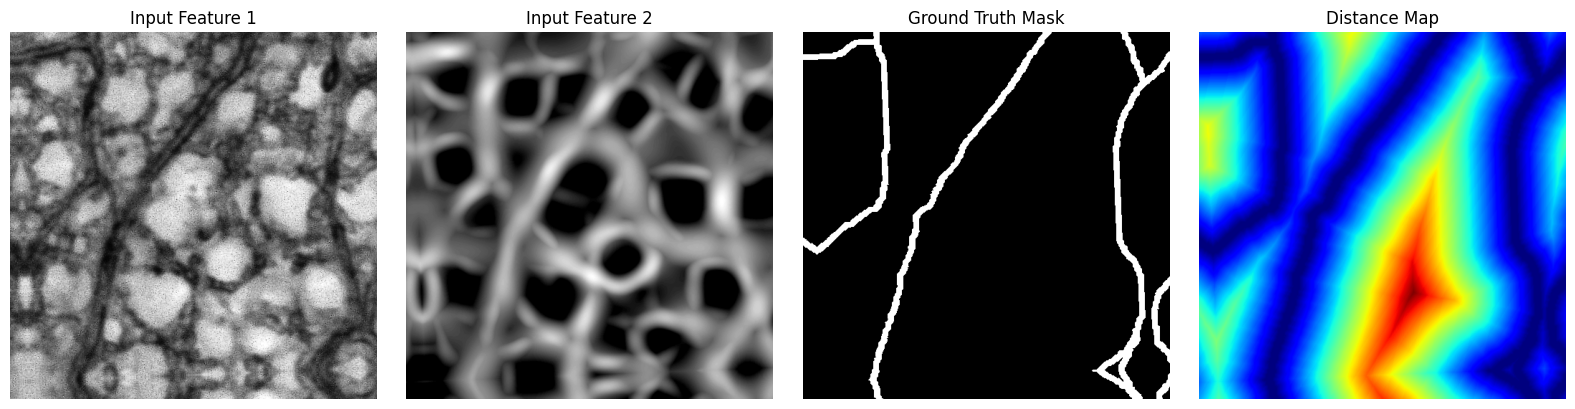

In [71]:
# Load a sample
dataset = LaticiferPatchTrain(
    feature_dirs={
        'image': 'datasets/laticifers/enhanced_images',
        'sato': 'datasets/laticifers/sato_images',
        'mask': 'datasets/laticifers/masks',
        'distance': 'datasets/laticifers/distance_maps_pt'
    },
    patches_per_image=1,
    #positive_ratio=1.0,
    dist_transform=True,
    #fg_threshold=0.05
)
sample = dataset[0]  # x: input, y: mask, d: distance map
x, y, d = sample['inputs'], sample['masks'], sample['dist_maps']

num_channels = x.shape[0]
print(x.shape)
# Plot all input feature channels
fig, axes = plt.subplots(1, num_channels + 2, figsize=(4 * (num_channels + 2), 4))

for i in range(num_channels):
    if i == 0:
        feature = x[i].cpu() * 0.5 + 0.5
    else:
        feature = x[i].cpu() * 0.5 + 0.5
    print(f"max: {feature.max()}, min: {feature.min()}")
    axes[i].imshow(feature, cmap='gray')
    axes[i].set_title(f'Input Feature {i + 1}')
    axes[i].axis('off')

# Plot the mask
axes[num_channels].imshow(y.squeeze().cpu(), cmap='gray')
axes[num_channels].set_title('Ground Truth Mask')
axes[num_channels].axis('off')
print(f"Mask max: {y.max()}, min: {y.min()}")
print("Mask unique values:", torch.unique(y))
# Plot the distance map
axes[num_channels + 1].imshow(d.squeeze().cpu(), cmap='jet')
axes[num_channels + 1].set_title('Distance Map')
axes[num_channels + 1].axis('off')

plt.tight_layout()
plt.show()